In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# === YOUR FOLDER PATHS ===
ROOT_DATA_DIR = r"C:\Users\LENOVO\OneDrive\Desktop\Project"
INPUT_MASKS_DIR = os.path.join(ROOT_DATA_DIR, "PROCESSED_DEFECT_MASKS")
ORIGINAL_IMAGES_DIR = os.path.join(ROOT_DATA_DIR, "images")
OUTPUT_ROIS_DIR = os.path.join(ROOT_DATA_DIR, "CLASSIFICATION_ROIS_128x128")

In [2]:
# Create output folder if not exists
os.makedirs(OUTPUT_ROIS_DIR, exist_ok=True)

# Defect categories
DEFECT_TYPES = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

# Constants
TARGET_SIZE = (128, 128)
MIN_DEFECT_AREA = 100  # To ignore small noise

print(f"Input Masks Dir: {INPUT_MASKS_DIR}")
print(f"Output ROIs Dir: {OUTPUT_ROIS_DIR}")
print(f"Target ROI Size: {TARGET_SIZE}")


Input Masks Dir: C:\Users\LENOVO\OneDrive\Desktop\Project\PROCESSED_DEFECT_MASKS
Output ROIs Dir: C:\Users\LENOVO\OneDrive\Desktop\Project\CLASSIFICATION_ROIS_128x128
Target ROI Size: (128, 128)


In [3]:

# --- FUNCTION TO CROP AND SAVE ROIs ---
def extract_and_save_rois(mask_path, original_img_path, defect_label):
    """
    Detect contours in mask, crop corresponding regions from the original image,
    resize them, and save them for training.
    """

    mask = cv2.imread(mask_path, 0)
    original_img = cv2.imread(original_img_path)

    if mask is None or original_img is None:
        print(f"Skipping {mask_path}: missing image.")
        return 0, None

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Directory for saving
    save_dir = os.path.join(OUTPUT_ROIS_DIR, defect_label)
    os.makedirs(save_dir, exist_ok=True)

    roi_count = 0
    viz_image = original_img.copy()

    for i, contour in enumerate(contours):
        if cv2.contourArea(contour) < MIN_DEFECT_AREA:
            continue

        # Bounding box
        x, y, w, h = cv2.boundingRect(contour)

        # Add padding to the crop
        padding = 10
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(original_img.shape[1], x + w + padding)
        y2 = min(original_img.shape[0], y + h + padding)

        # Crop the region
        cropped_roi = original_img[y1:y2, x1:x2]
        if cropped_roi.size == 0:
            continue

        # Resize to target size
        final_roi = cv2.resize(cropped_roi, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)

        # Save with proper name
        roi_filename = f"{defect_label}_{os.path.basename(original_img_path).replace('.JPG', '').replace('.jpg', '')}_{i}.png"
        cv2.imwrite(os.path.join(save_dir, roi_filename), final_roi)

        roi_count += 1

        # Draw rectangle for visualization
        cv2.rectangle(viz_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(viz_image, defect_label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return roi_count, viz_image

In [4]:
# --- MAIN LOOP ---
total_rois_extracted = 0
sample_visualizations = []

for defect_type in DEFECT_TYPES:
    print(f"\nStarting ROI extraction for: {defect_type}")

    mask_dir = os.path.join(INPUT_MASKS_DIR, defect_type)
    if not os.path.exists(mask_dir):
        print(f"⚠️ No mask directory found for {defect_type}")
        continue

    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

    for mask_filename in mask_files:
        original_test_name = mask_filename.replace('MASK_', '').replace('.png', '.JPG')
        original_img_path = os.path.join(ORIGINAL_IMAGES_DIR, defect_type, original_test_name)
        mask_path = os.path.join(mask_dir, mask_filename)

        extracted_count, viz_output = extract_and_save_rois(mask_path, original_img_path, defect_type)
        total_rois_extracted += extracted_count

        # Save one visualization example per defect type
        if extracted_count > 0 and defect_type not in [s[0] for s in sample_visualizations]:
            sample_visualizations.append((defect_type, viz_output))


print(f"\n\n✅ TOTAL ROIs Extracted and Saved: {total_rois_extracted}")
print("Displaying one sample for each defect type...")



Starting ROI extraction for: Missing_hole

Starting ROI extraction for: Mouse_bite

Starting ROI extraction for: Open_circuit

Starting ROI extraction for: Short

Starting ROI extraction for: Spur

Starting ROI extraction for: Spurious_copper


✅ TOTAL ROIs Extracted and Saved: 3057
Displaying one sample for each defect type...


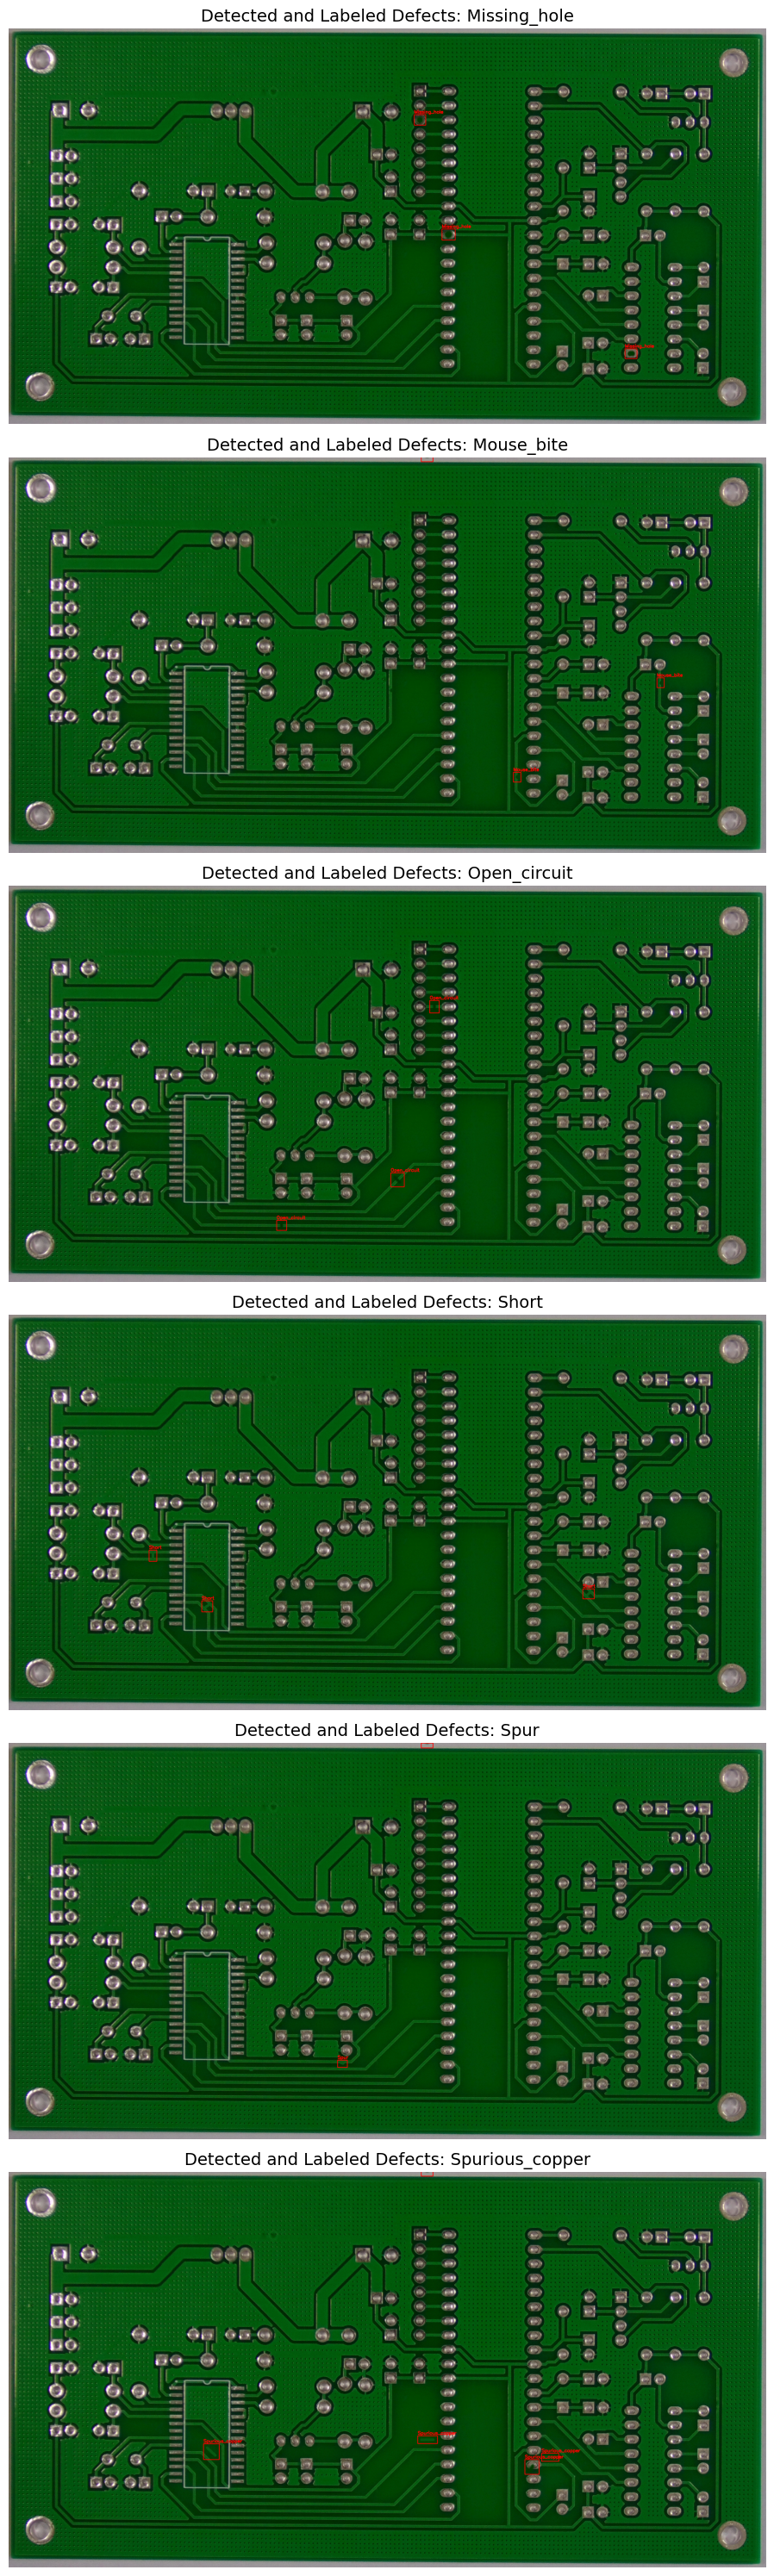


✅ Cropped ROIs are resized to (128, 128) and saved in:
C:\Users\LENOVO\OneDrive\Desktop\Project\CLASSIFICATION_ROIS_128x128


In [5]:
# --- VISUALIZATION ---
num_samples = len(sample_visualizations)
plt.figure(figsize=(18, 5 * num_samples))

for idx, (defect_type, img) in enumerate(sample_visualizations):
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(img_rgb)
        plt.title(f"Detected and Labeled Defects: {defect_type}", fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Cropped ROIs are resized to {TARGET_SIZE} and saved in:")
print(OUTPUT_ROIS_DIR)